In [1]:
import pandas as pd
import numpy as np
import time

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from river import evaluate
from river import metrics
from AdaptiveALMA import AdaptiveALMA

from river import stream, compose, drift
from river import preprocessing
from river import linear_model as ln
%matplotlib inline

In [2]:
#Loading the dataset
data= pd.read_csv("/Users/promisea/Auto_Online_Datasets/wustl-scada-2018.csv")

In [3]:
data

,Sport,TotPkts,TotBytes,SrcPkts,DstPkts,SrcBytes,Target
0,143,2,180,2,0,180,0
1,68,2,684,2,0,684,0
2,0,1,60,1,0,60,0
3,54949,10,628,4,6,248,0
4,54943,8,496,4,4,248,0
...,...,...,...,...,...,...,...
7037978,49317,14,904,8,6,520,0
7037979,49318,14,904,8,6,520,0
7037980,49319,12,780,8,4,520,0
7037981,49320,12,780,8,4,520,0


In [4]:
print('Original dataset shape %s' % Counter(data['Target']))

Original dataset shape Counter({0: 6634581, 1: 403402})


In [5]:
normal_drop = data[data['Target'] == 0]

In [6]:
attack_drop = data[data['Target'] == 1]

In [7]:
attack_to_remove = attack_drop[:353402]

In [8]:
normal_to_remove = normal_drop[:6584581]

In [9]:
data = data.drop(normal_to_remove.index)

In [10]:
data = data.drop(attack_to_remove.index)

In [11]:
data.shape

(100000, 7)

In [12]:
data.to_csv('scada_modified.csv', index=False)

In [13]:
X = data.drop(['Target'], axis=1)
y = data['Target']

In [14]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 50000, 0: 50000})


In [15]:
X, y = shuffle(X, y, random_state=42)

In [16]:
dataset = stream.iter_pandas(X, y)

In [17]:
ALMA = compose.Pipeline(
    preprocessing.StandardScaler(),
    ln.ALMAClassifier()
)

In [18]:
dataset = stream.iter_pandas(X, y)

In [19]:
#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [20]:
%%time

evaluate.progressive_val_score(dataset, ALMA, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      96.43%   97.36%   96.89%     24966  
       1      97.34%   96.40%   96.87%     25034  
                                                  
   Macro      96.88%   96.88%   96.88%            
   Micro      96.88%   96.88%   96.88%            
Weighted      96.88%   96.88%   96.88%            

                 96.88% accuracy                   – 00:00:01 – 4.24 KB
[100,000]            Precision   Recall   F1       Support  
                                                  
       0      96.25%   97.07%   96.66%     50000  
       1      97.05%   96.21%   96.63%     50000  
                                                  
   Macro      96.65%   96.64%   96.64%            
   Micro      96.64%   96.64%   96.64%            
Weighted      96.65%   96.64%   96.64%            

                 96.64% accuracy                   – 00:00:02 – 4.24 KB
CPU times: user 2.7

           Precision   Recall   F1       Support  
                                                  
       0      96.25%   97.07%   96.66%     50000  
       1      97.05%   96.21%   96.63%     50000  
                                                  
   Macro      96.65%   96.64%   96.64%            
   Micro      96.64%   96.64%   96.64%            
Weighted      96.65%   96.64%   96.64%            

                 96.64% accuracy                  

In [40]:
dataset = stream.iter_pandas(X, y)

In [41]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

In [42]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

[50,000]            Precision   Recall   F1       Support  
                                                  
       0      95.47%   98.09%   96.76%     82487  
       1      98.03%   95.35%   96.67%     82513  
                                                  
   Macro      96.75%   96.72%   96.72%            
   Micro      96.72%   96.72%   96.72%            
Weighted      96.75%   96.72%   96.72%            

                 96.72% accuracy                   – 00:00:01 – 11.06 KB
[100,000]            Precision   Recall   F1       Support  
                                                  
       0      95.83%   98.34%   97.07%    107521  
       1      98.30%   95.72%   96.99%    107479  
                                                  
   Macro      97.06%   97.03%   97.03%            
   Micro      97.03%   97.03%   97.03%            
Weighted      97.06%   97.03%   97.03%            

                 97.03% accuracy                   – 00:00:03 – 10.99 KB
CPU times: user 3

           Precision   Recall   F1       Support  
                                                  
       0      95.83%   98.34%   97.07%    107521  
       1      98.30%   95.72%   96.99%    107479  
                                                  
   Macro      97.06%   97.03%   97.03%            
   Micro      97.03%   97.03%   97.03%            
Weighted      97.06%   97.03%   97.03%            

                 97.03% accuracy                  

In [24]:
dataset = stream.iter_pandas(X, y)

In [25]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__
    
    # Creating a single plot for accuracy
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    threshold_reached_step = None  # To store the step where accuracy reaches 75%

    for model_name, model in models.items():
        steps = []
        accuracies = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=False, measure_memory=False, step=20
        ):
            current_step = checkpoint["Step"]
            current_accuracy = checkpoint[metric_name].get()
            steps.append(current_step)
            accuracies.append(current_accuracy)

            # Check if the accuracy reaches 75% for the first time
            if current_accuracy >= 0.75 and threshold_reached_step is None:
                threshold_reached_step = current_step

        ax.plot(steps, accuracies, label=model_name)

        # Draw a vertical red line and annotate if the threshold is reached
        if threshold_reached_step:
            ax.axvline(x=threshold_reached_step, color='red', linestyle='--')
            ax.annotate(f'{threshold_reached_step} samples', xy=(threshold_reached_step, 0.75),
                        xytext=(threshold_reached_step + 50, 0.80),
                        arrowprops=dict(facecolor='blue', shrink=0.05),
                        horizontalalignment='left', verticalalignment='top')

    ax.set_ylabel('Accuracy', fontweight='bold')
    ax.set_xlabel('# Samples', fontweight='bold')
    ax.grid(True)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.15),
        ncol=1, fancybox=True, shadow=True
    )
    
    # Apply bold formatting directly to tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig('Performance_ALMA_SCADA.png')
    plt.close()

    return fig

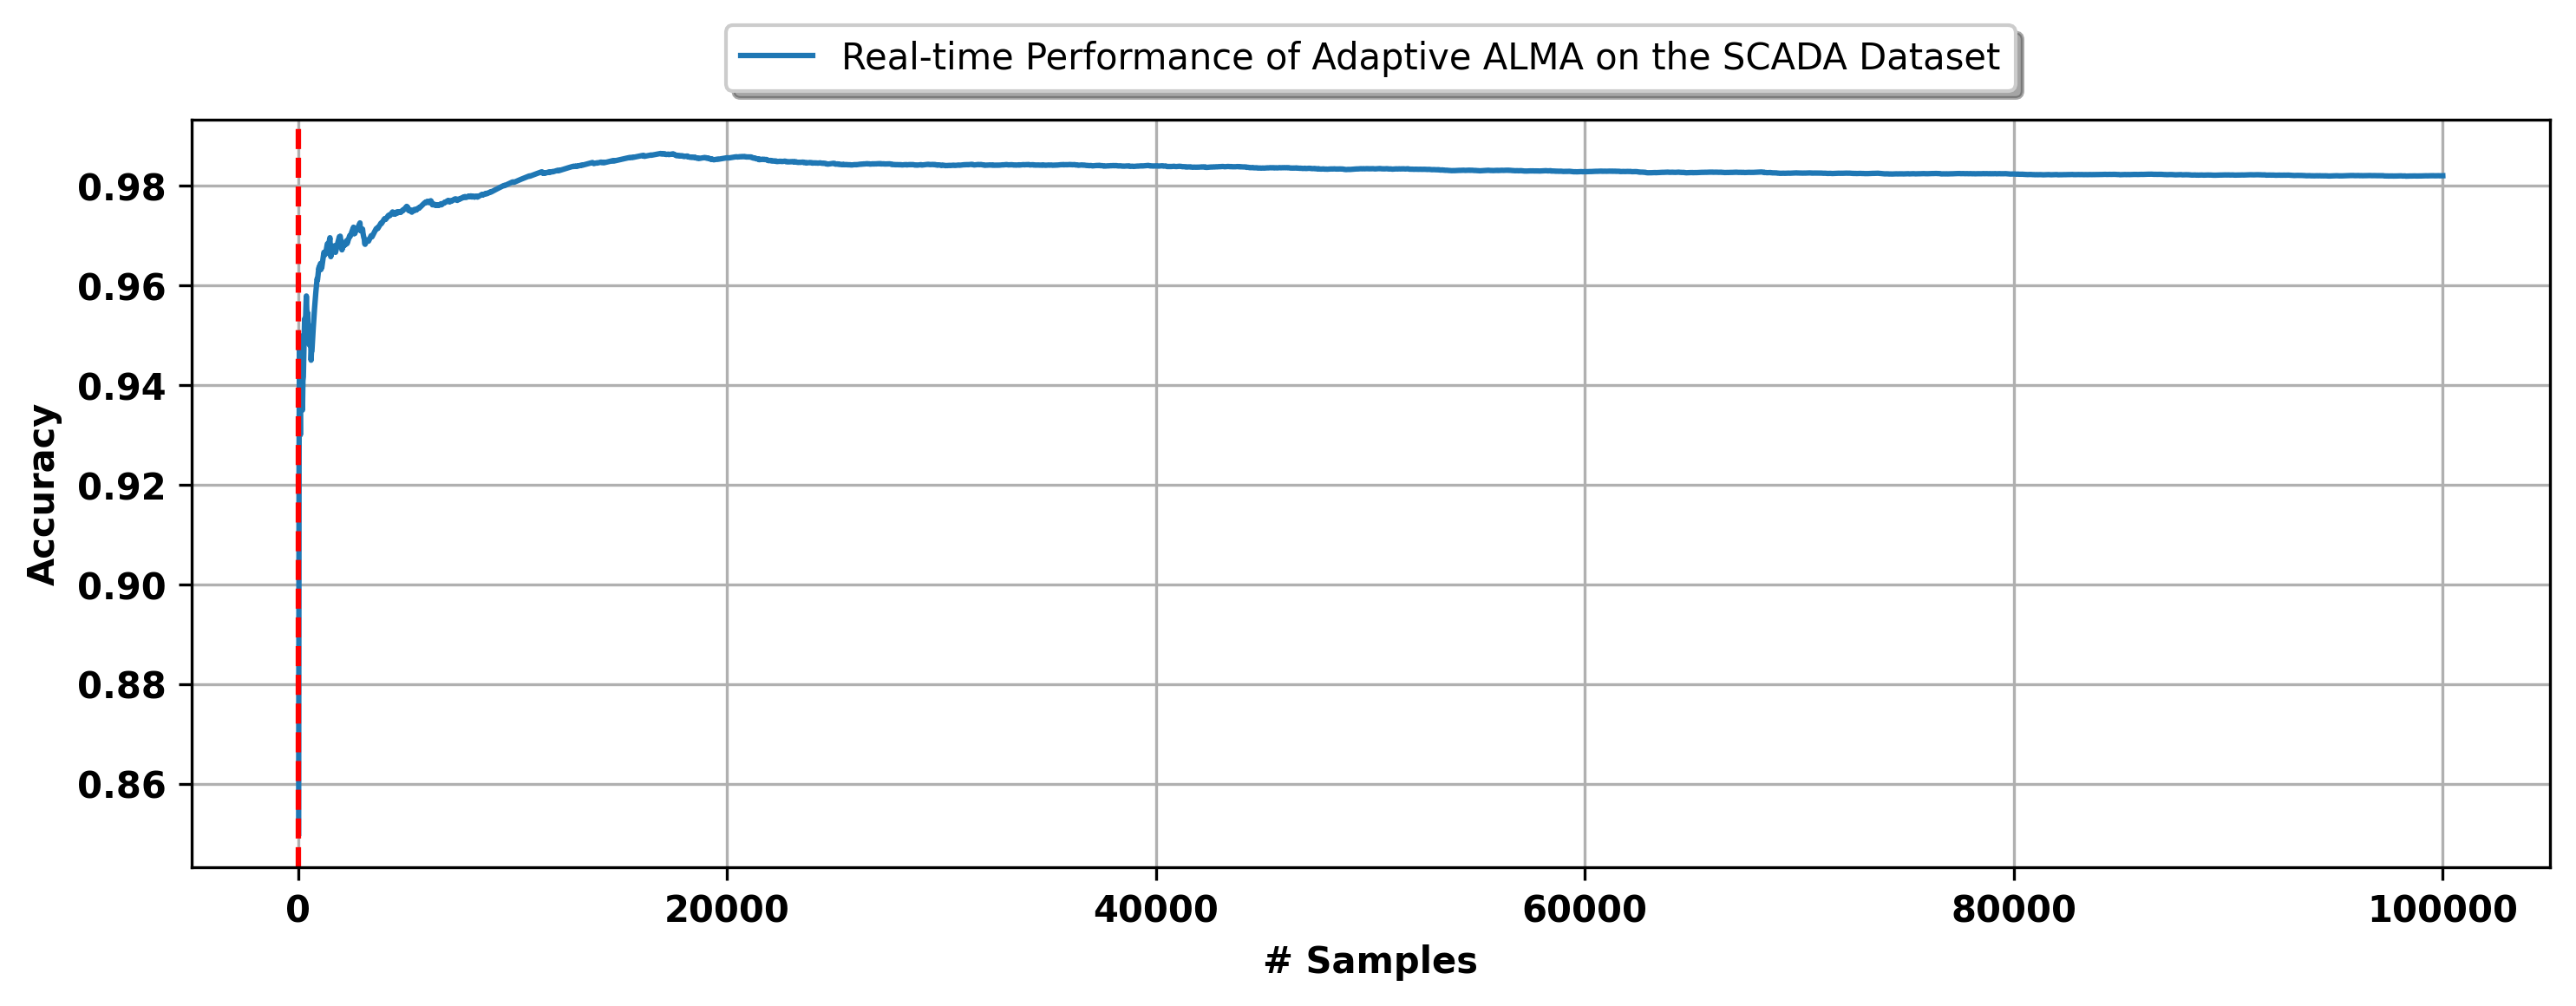

In [26]:
plot_performance(
    dataset,
    metrics.Accuracy(),
    {
        "Real-time Performance of Adaptive ALMA on the SCADA Dataset": (
            preprocessing.StandardScaler() | AdaptiveALMA()
        )
    }
)

In [27]:
#Loading the dataset
data= pd.read_csv("scada_modified.csv")
print('Original dataset shape  %s' % Counter(data['Target']))
X = data.drop(['Target'], axis=1)
y = data['Target']
X, y = shuffle(X, y, random_state=42)

Original dataset shape  Counter({1: 50000, 0: 50000})


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, random_state=100, stratify=data['Target'])


model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [29]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 154 ms, sys: 1.55 ms, total: 156 ms
Wall time: 156 ms


           Precision   Recall   F1       Support  
                                                  
       0      96.46%   99.22%   97.82%      2447  
       1      99.23%   96.51%   97.86%      2553  
                                                  
   Macro      97.85%   97.87%   97.84%            
   Micro      97.84%   97.84%   97.84%            
Weighted      97.88%   97.84%   97.84%            

                 97.84% accuracy                  

In [30]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 95% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 95% unseen samples
Accuracy: 0.9814526315789474
Precision: 0.9922210011420691
Recall: 0.9704723164794402
F1_Score: 0.981226159780084


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90, random_state=100, stratify=data['Target'])


model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [32]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 328 ms, sys: 7.93 ms, total: 336 ms
Wall time: 331 ms


           Precision   Recall   F1       Support  
                                                  
       0      77.50%   84.47%   80.83%      4978  
       1      83.10%   75.69%   79.22%      5022  
                                                  
   Macro      80.30%   80.08%   80.03%            
   Micro      80.06%   80.06%   80.06%            
Weighted      80.31%   80.06%   80.02%            

                 80.06% accuracy                  

In [33]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 90% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 90% unseen samples
Accuracy: 0.8169222222222222
Precision: 0.8627835340240829
Recall: 0.7535017119480635
F1_Score: 0.8044481895109128


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.85, random_state=100, stratify=data['Target'])


model = compose.Pipeline(
    preprocessing.StandardScaler(),
    AdaptiveALMA()
)

dataset = stream.iter_pandas(X_train, y_train)

#Passing the evalaution metrics into a variable
report = metrics.ClassificationReport()

In [35]:
%%time

evaluate.progressive_val_score(dataset, model, report, print_every=50000, show_time=True, show_memory=True)

CPU times: user 493 ms, sys: 10.8 ms, total: 504 ms
Wall time: 499 ms


           Precision   Recall   F1       Support  
                                                  
       0      79.09%   87.70%   83.17%      7521  
       1      86.11%   76.68%   81.12%      7479  
                                                  
   Macro      82.60%   82.19%   82.15%            
   Micro      82.21%   82.21%   82.21%            
Weighted      82.59%   82.21%   82.15%            

                 82.21% accuracy                  

In [36]:
# Initialize metrics
Acc = metrics.Accuracy()
Pre = metrics.Precision()
Rec = metrics.Recall()
F1 = metrics.F1()

# Iterate over the test stream and update metrics
for xi, yi in stream.iter_pandas(X_test, y_test):
    y_pred = model.predict_one(xi)
    Acc.update(yi, y_pred)
    Pre.update(yi, y_pred)
    Rec.update(yi, y_pred)
    F1.update(yi, y_pred)

# Retrieve final metric values
Accuracy = Acc.get()
Precision = Pre.get()
Recall = Rec.get()
F1_Score = F1.get()

# Output the results
print("Printing the results for 85% unseen samples")
print("Accuracy:", Accuracy)
print("Precision:", Precision)
print("Recall:", Recall)
print("F1_Score:", F1_Score)

Printing the results for 85% unseen samples
Accuracy: 0.8414823529411765
Precision: 0.8999091334636672
Recall: 0.7686084522941605
F1_Score: 0.8290925695730486
